In [1]:
'''
This first cell imports and defines all necessary packages and functions through the rest of the code.
It also computes some info about CHIME near/far field, and info about the drone.
'''
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator
import numpy as np
import h5py
##From WT:
import datetime
import pytz
import os
import glob
from matplotlib import colors
import pandas
import csv
import pickle
%matplotlib inline
import beamcals
from beamcals import corr
from beamcals import concat
from beamcals import drone
from beamcals import bicolog
from beamcals import beammap
from beamcals import reduce_ccclass
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
import beamcals.reduce_ccclass as rc
from beamcals.sites import site
chimesite=site.site('/home/ec2274/newburghlabdrone/beamcals/beamcals/sites/CHIME_config.npz')
chime_cylC=site.site('/home/ec2274/newburghlabdrone/beamcals/beamcals/sites/CHIME_CylC_config.npz')
chime_cylC2=site.site('/home/ec2274/newburghlabdrone/beamcals/beamcals/sites/CHIME_CylC_config_v2.npz')

#phase unwrap:
from skimage.restoration import unwrap_phase

# Display settings:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))


## Define functions for the reactive NF, FF, and range of the radiating NF [all units cm]:
    #inputs are dish diameter (D) and wavelength (Lambda) both in cm!
    
def Reactive_NF_Distance_m(D,Lambda):
    return (1.0/100.0)*0.62*np.sqrt((D**3.0)/Lambda)

def FF_Distance_m(D,Lambda):
    return (1.0/100.0)*2.0*(D**2.0)/Lambda

def Radiative_NF_Bounds_m(D,Lambda):
    return [Reactive_NF_Distance_m(D,Lambda),FF_Distance_m(D,Lambda)]

from scipy.optimize import curve_fit
from scipy.optimize import least_squares

## Import auxilary packages:
from astropy.coordinates import EarthLocation,SkyCoord
from astropy.time import Time
from astropy import units as u
from astropy.coordinates import AltAz
import astropy.coordinates as coord


## DEFN the Gauss Fit function:
def Gauss_opt(P,x,V):
    a,x0,sigma,k=P
    return a*np.exp(-(x-x0)**2.0/(2.0*sigma**2.0))+k-V

def telescopeCoords(HA,Dec,lat=49.320751,deg=False):
    '''Return telescope coordinates[
    y (sine of zenith angle) increasing to the North
    x increasing to the east
    for HA, Dec given in degrees
    if deg=True, y is[returned as[zenith angle in degrees[(North positive)
    '''
    # convert celestial coordinates[to theta,phi
    t = np.radians(90. - Dec)
    p = -1.*np.radians(HA)
    # convert theta,phi to X vector in celestial frame
    # x_hat = in equitorial plane pointing toward 0 HA
    # y_hat = in equitorial plane pointing toward -90 HA (East)
    # z_hat = north celestial pole
    x = np.sin(t)*np.cos(p)
    y = np.sin(t)*np.sin(p)
    z = np.cos(t)
    X = np.stack((x,y,z),axis=-1)
    # rotate X to X' in telescope frame
    # x'_hat = zenith
    # y'_hat = East
    # z'_hat = North
    beta = np.radians(lat)
    k = np.array([0,1,0])[np.newaxis,:]
    Xp = np.cos(beta)*X
    Xp += np.sin(beta)*np.cross(k,X)
    Xp += np.inner(X,k)*(1-np.cos(beta))*k
    # convert X' to theta',phi' in telescope frame
    bxp,byp,bzp = np.transpose(Xp)
    tp = np.arctan2(np.sqrt(bxp**2 + byp**2),bzp)
    pp = np.arctan2(byp,bxp)
    # convert theta',phi' to telescope x,y
    za = 0.5*np.pi - tp
    if deg:
        y = np.degrees(za) 
    else:
        y = np.sin(za)
    x = np.sin(tp)*np.sin(pp)
    return (y,x)

def ground_to_sph(x,y,lat=49.320751*(np.pi/180.0)):
    """Get the CIRS coordinates.

    Latitude is given in radians. Assumes z is positive

    Parameters
    ----------
    x : array_like
        The East projection of the angular position
    y : array_like
        The North projection of the angular position
    lat : array_like
        The latitude of the observatory.

    Returns
    -------
    ha, dec: array_like
        Hour Angle and declination in radians
    """
    z = np.sqrt(1 - x**2 - y**2)

    xe = z * np.cos(lat) - y * np.sin(lat)
    ye = x
    ze = y * np.cos(lat) + z * np.sin(lat)

    ha = -1 * np.arctan2(ye, xe)
    dec = np.arctan2(ze, np.sqrt(xe**2 + ye**2))

    return ha, dec

CHIME_ANG=0.071#deg

def CHIME_2d_Rot(X,Y,theta=CHIME_ANG):
    xp=X*np.cos(theta*np.pi/180.0)-Y*np.sin(theta*np.pi/180.0)
    yp=X*np.sin(theta*np.pi/180.0)+Y*np.cos(theta*np.pi/180.0)
    return [xp,yp]

##Directories
dronedir='/hirax/CHIME_Oct_2022/20221025_CHIME_DJI_Data/'

## Specify frequency and wavelength ranges for correlator:
freq=np.linspace(800,400,1024)
wavelength=3e10/(1e6*freq)
CHIME_D=20.0*100
print("Minimum frequency = {:.2f}MHz is maximum wavelength = {:.2f}cm".format(min(freq),max(wavelength)))
print("Maximum frequency = {:.2f}MHz is minimum wavelength = {:.2f}cm".format(max(freq),min(wavelength)))

## What should the grid spacing look li700,650ke? (lam700,650bda/2 for nyquist sampling...)
print("Nyquist sampling grid spacing is min(wavelength)/2 = {:.2f}cm".format(min(wavelength)/2.0))

## What altitude should we do the flight at to be in the radiating nearfield?
print(Radiative_NF_Bounds_m(CHIME_D,min(wavelength)))
print(Radiative_NF_Bounds_m(CHIME_D,max(wavelength)))
print("Maximum Radiating NF Altitude for our frequency range = {:.2f}m".format(Reactive_NF_Distance_m(CHIME_D,min(wavelength))))
print("Minimum FF Altitude for our frequency range = {:.2f}m".format(FF_Distance_m(CHIME_D,max(wavelength))))

delX=11.0 #0.2143 #m
delY=11.0 #0.2143 #m
delT=2.0 #sec
grid_alt=305 #25.0
# I will suggest ~25.0m above the feeds, since this will give us some cushion for the autopilot offsets.

## If we want to measure E field components for points +30deg to -30deg from zenith at 25m,
## Then our grid would have sides of length 28.86m to measure one dish centered at (0,0)...
grid_sidelength=2*(grid_alt*np.tan(np.pi/180.0*30.0))
print("For a {}m alt grid that spans [+30.0,-30.0] deg, sides must be {:.2f}m".format(grid_alt,grid_sidelength))
## How many points will a pass contain if sampled at nyquist freq?
grid_pts_per_pass=int(np.ceil(grid_sidelength/delX))
print("If sampled at nyquist [{}m] each pass will contain {} points".format(delX,grid_pts_per_pass))
## How many points would the grid contain?
grid_num_pts=grid_pts_per_pass**2
print("The grid would then contain {} points".format((grid_num_pts)))
## How long would a flight take?
grid_flight_time=grid_num_pts*delT/60
print("The flight would take approximately {:.2f} minutes".format(grid_flight_time))
## How fast should the drone fly?
grid_flight_speed=(delX/delT)
print("If sampled at nyquist [{}m] the drone can fly at {:.2f}m/s".format(delX,grid_flight_speed))

Minimum frequency = 400.00MHz is maximum wavelength = 75.00cm
Maximum frequency = 800.00MHz is minimum wavelength = 37.50cm
Nyquist sampling grid spacing is min(wavelength)/2 = 18.75cm
[90.55679617418745, 2133.3333333333335]
[64.03332465729596, 1066.6666666666667]
Maximum Radiating NF Altitude for our frequency range = 90.56m
Minimum FF Altitude for our frequency range = 1066.67m
For a 305m alt grid that spans [+30.0,-30.0] deg, sides must be 352.18m
If sampled at nyquist [11.0m] each pass will contain 33 points
The grid would then contain 1089 points
The flight would take approximately 36.30 minutes
If sampled at nyquist [11.0m] the drone can fly at 5.50m/s


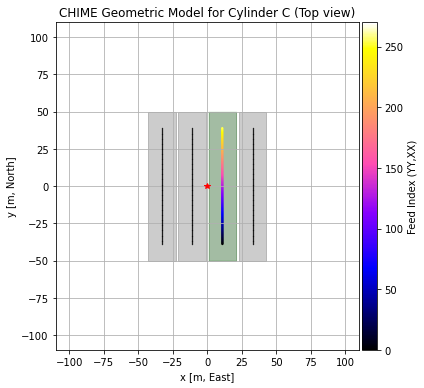

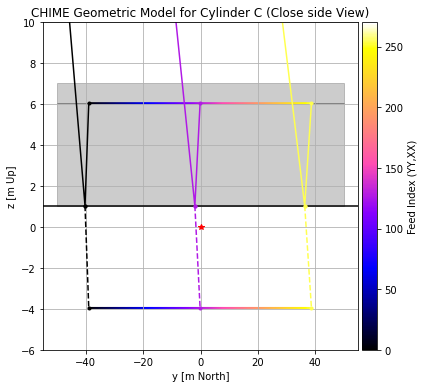

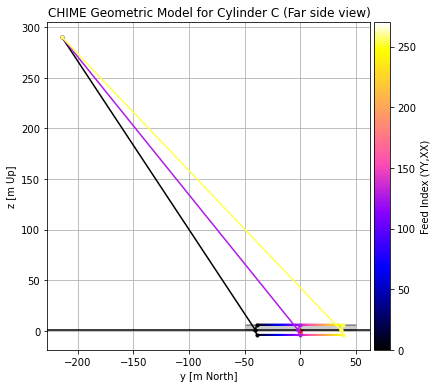

In [2]:
##Geometric Model for CHIME Cylinder C. 

fig,ax=subplots(nrows=1,ncols=1,figsize=(6,5.5),sharex=True,sharey=True)
xlim(-110,110)
ylim(-110,110)
plot(0,0,'r*')
for j in [-33,-11,11,33]:
    x=np.array([j-10,j+10])
    y1=np.array([-50,-50])
    y2=np.array([50,50])
    xf=j*np.ones(256)
    yf=np.linspace(-0.3048*(256/2),+0.3048*(256/2),256)
    xf0,yf0=CHIME_2d_Rot(xf,yf)
    x0,y10=CHIME_2d_Rot(x,y1)
    x0,y20=CHIME_2d_Rot(x,y2)
    fill_between(x,y1,y2,color='k',alpha=0.2)
    if j in [-33,-11,33]:
        plot(xf,yf,'k.',markersize=0.5)
        #fill_between(x0,y10,y20,color='r',alpha=0.2)
        #plot(xf0,yf0,'r.',markersize=0.5)
    if j in [11]:
        fill_between(x0,y10,y20,color='g',alpha=0.2)
        im=ax.scatter(xf0,yf0,c=range(256),vmin=0,vmax=270,s=1,cmap='gnuplot2')
divider=make_axes_locatable(ax)
cax=divider.append_axes("right", size="5%", pad=0.05)
cbar=fig.colorbar(im,cax=cax)
cbar.set_label('Feed Index (YY,XX)')
ax.set_title("CHIME Geometric Model for Cylinder C (Top view)")
ax.set_xlabel('x [m, East]')
ax.set_ylabel('y [m, North]')
ax.grid()
tight_layout()

fig1,ax1=subplots(nrows=1,ncols=1,figsize=(6,5.5),sharex=True,sharey=True)
xlim(-55,55)
ylim(-6,10)
plot(0,0,'r*')
y=np.array([-50,50])
dx,dy,dz=[0,-214,290]
z1=np.array([1.047,1.047])
z2=np.array([6.047,6.047])
z3=np.array([7.047,7.047])
yf=np.linspace(-0.3048*(256/2),+0.3048*(256/2),256)
zf=6.047*np.ones(256)
fill_between(y,z1,z2,color='k',alpha=0.2)
fill_between(y,z2,z3,color='k',alpha=0.2)
im=ax1.scatter(yf,zf,c=range(256),vmin=0,vmax=270,s=1,cmap='gnuplot2')
divider=make_axes_locatable(ax1)
cax1=divider.append_axes("right", size="5%", pad=0.05)
cbar=fig1.colorbar(im,cax=cax1)
cbar.set_label('Feed Index (YY,XX)')
ax1.set_title("CHIME Geometric Model for Cylinder C (Close side View)")
ax1.set_xlabel('y [m North]')
ax1.set_ylabel('z [m Up]')
ax1.grid()
tight_layout()
ax1.axhline(1.047,color='k')
zi=-3.953*np.ones(256)
yi=np.linspace(-0.3048*(256/2),+0.3048*(256/2),256)
zb=1.047*np.ones(256)
yb=[zb[i]+(-1.0*(dz-(((zi[i]-dz)/(yi[i]-dy))*dy)))/((zi[i]-dz)/(yi[i]-dy)) for i in range(256)]
colorsarr=cm.gnuplot2(np.linspace(0,1,270))
for i in range(256)[::127]:
    ax1.plot([dy,yb[i],yf[i]],[dz,zb[i],zf[i]],'.-',c=colorsarr[i])
    ax1.plot([yb[i],yi[i]],[zb[i],zi[i]],'.--',c=colorsarr[i])
im=ax1.scatter(yi,zi,c=range(256),vmin=0,vmax=270,s=1,cmap='gnuplot2')

fig1,ax1=subplots(nrows=1,ncols=1,figsize=(6,5.5),sharex=True,sharey=True)
# xlim(-55,55)
# ylim(-6,10)
plot(0,0,'r*')
y=np.array([-50,50])
dx,dy,dz=[0,-214,290]
z1=np.array([1.047,1.047])
z2=np.array([6.047,6.047])
z3=np.array([7.047,7.047])
yf=np.linspace(-0.3048*(256/2),+0.3048*(256/2),256)
zf=6.047*np.ones(256)
fill_between(y,z1,z2,color='k',alpha=0.2)
fill_between(y,z2,z3,color='k',alpha=0.2)
im=ax1.scatter(yf,zf,c=range(256),vmin=0,vmax=270,s=1,cmap='gnuplot2')
divider=make_axes_locatable(ax1)
cax1=divider.append_axes("right", size="5%", pad=0.05)
cbar=fig1.colorbar(im,cax=cax1)
cbar.set_label('Feed Index (YY,XX)')
ax1.set_title("CHIME Geometric Model for Cylinder C (Far side view)")
ax1.set_xlabel('y [m North]')
ax1.set_ylabel('z [m Up]')
ax1.grid()
tight_layout()
ax1.axhline(01.047,color='k')
zi=-3.953*np.ones(256)
yi=np.linspace(-0.3048*(256/2),+0.3048*(256/2),256)
zb=1.047*np.ones(256)
yb=[zb[i]+(-1.0*(dz-(((zi[i]-dz)/(yi[i]-dy))*dy)))/((zi[i]-dz)/(yi[i]-dy)) for i in range(256)]
colorsarr=cm.gnuplot2(np.linspace(0,1,270))
for i in range(256)[::127]:
    ax1.plot([dy,yb[i],yf[i]],[dz,zb[i],zf[i]],'.-',c=colorsarr[i])
    ax1.plot([yb[i],yi[i]],[zb[i],zi[i]],'.--',c=colorsarr[i])
im=ax1.scatter(yi,zi,c=range(256),vmin=0,vmax=270,s=1,cmap='gnuplot2')

In [2]:
## Drone flight Data: y throw complex data:
gaindir='/hirax/20220824_WLC_NFandFF/WLC_Corr_Data/20220825T202602Z_Suit_digitalgain/'
datadir='/hirax/CHIME_Oct_2022/20221028T193745Z_chimedronecal_corr/'
NScorr=corr.Corr_Data(Data_Directory=datadir,Gain_Directory=gaindir,Data_File_Index=range(3),Fix_Gains=True,Gain_Params=[1,1],Apply_Gains=False,Load_Gains=False,crossmap=[],site_class=chime_cylC2,use_ctime=True)
#EWN2corr=corr.Corr_Data(Data_Directory=datadir,Gain_Directory=gaindir,Data_File_Index=range(7,9),Fix_Gains=True,Gain_Params=[1,1],Apply_Gains=False,Load_Gains=False,crossmap=list(range(98176-256,98176+256)),site_class=chimesite,use_ctime=True)
#Print statement "Loading File:" is WRONG!!!
NSdrone=drone.Drone_Data(dronedir,'FLY753.csv',site_class=chime_cylC2)
NScorr.gainfile='lol'
NScorr.t_arr_datetime=np.array([x+1/2*(NScorr.t_arr_datetime[1]-NScorr.t_arr_datetime[0]) for x in NScorr.t_arr_datetime])
NSconcat=concat.CONCAT(CORRDATCLASS=NScorr,DRONEDATCLASS=NSdrone,\
                       config_directory="/hirax/CHIME_Oct_2022/outputs/",\
                       output_directory="/hirax/CHIME_Oct_2022/outputs/",\
                       load_yaml=False,save_traceback=False)

Initializing Correlator Class using:
  --> /hirax/CHIME_Oct_2022/20221028T193745Z_chimedronecal_corr/
  --> Arrays initialized with shape (3, 256, 1024, 512)
Assigning array values by reading in data files:
  --> Loading File: 00000998_0000.h5/00000998_0000.h5
  --> Finished. Reshaping arrays.
Initializing drone data via datcon_csv routine: FLY753.csv
  --> Skipping rows 1 to 499 to eliminate NAN values
  --> Attempting to load position data from RTK
    --> RTK data contains 9591/9591 non-nan values
Timestamp interpolation succeeded
  --> generating llh, geocentric cartesian, local cartesian, and local spherical coordinates.
  --> generating dish and receiver line of sight coordinates.
Initializing CONCAT CLASS with active traceback using:
  --> /hirax/CHIME_Oct_2022/20221028T193745Z_chimedronecal_corr/
  --> FLY753.csv
  --> Traceback outputs will not be saved...
Concat initialized without previous config file...
Interpolating drone coordinates for each correlator timestamp:
  --> co

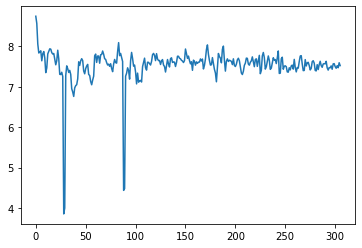

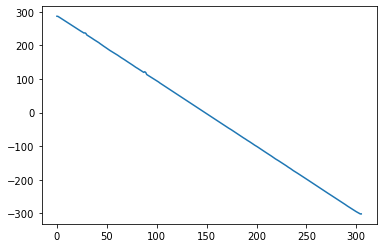

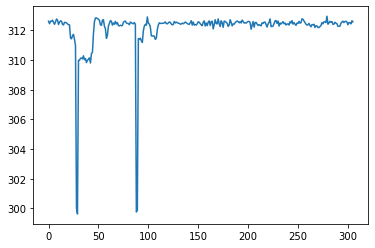

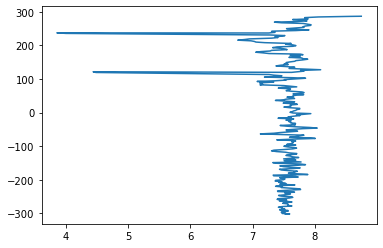

In [12]:
plt.plot(NSconcat.drone_xyz_LC_interp[187:493,0])
plt.show()
plt.plot(NSconcat.drone_xyz_LC_interp[187:493,1])
plt.show()
plt.plot(NSconcat.drone_xyz_LC_interp[187:493,2])
plt.show()
plt.plot(NSconcat.drone_xyz_LC_interp[187:493,0], NSconcat.drone_xyz_LC_interp[187:493,1])

#[187:493] is the time window where the drone does one NS pass

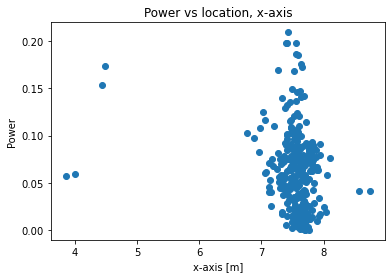

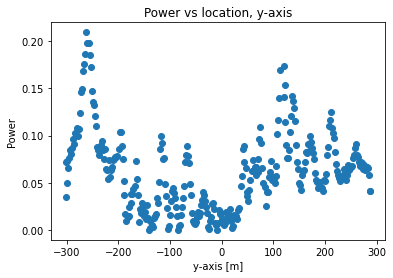

In [5]:
tlb, tub = [187,493]
feed = 2
#xmg, ymg = np.meshgrid(EWN2concat.drone_xyz_LC_interp[tlb:tub,0], EWN2concat.drone_xyz_LC_interp[tlb:tub,1])
pwrNS= np.abs(np.transpose(NSconcat.V[tlb:tub,:,feed]))[44,:] #Index 44 corresponds to 525 MHz

plt.scatter(NSconcat.drone_xyz_LC_interp[tlb:tub,0], pwrNS)#, c=EWN2concat.drone_xyz_LC_interp[tlb:tub,1], cmap='cool', s=20, alpha=1)
plt.title('Power vs location, x-axis')
plt.xlabel('x-axis [m]')
plt.ylabel('Power')
plt.show()

plt.scatter(NSconcat.drone_xyz_LC_interp[tlb:tub,1], pwrNS)#, c=EWN2concat.drone_xyz_LC_interp[tlb:tub,1], cmap='cool', s=20, alpha=1)
plt.title('Power vs location, y-axis')
plt.xlabel('y-axis [m]')
plt.ylabel('Power')
plt.show()

In [23]:
print(NSconcat.drone_xyz_LC_interp.shape)

(768, 3)


(768, 1024, 512)


Text(0, 0.5, 'y [m]')

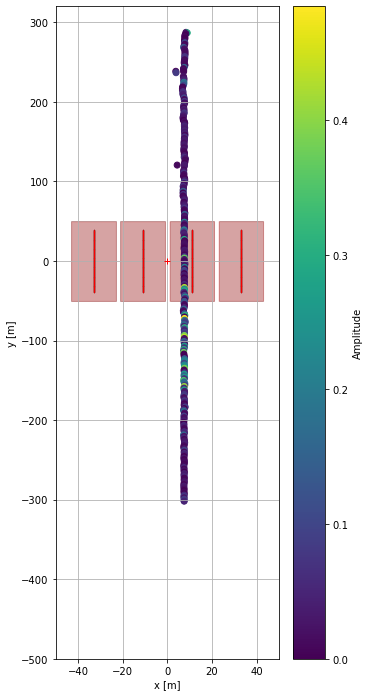

In [6]:
figure(figsize=(5,12))
#xlim(-50,50)
xlim(-50,50)
ylim(-500,320)
plot(0,0,'r+')
for j in [-33,-11,11,33]:
    x=np.array([j-10,j+10])
    y1=np.array([-50,-50])
    y2=np.array([50,50])
    fill_between(x,y1,y2,color='k',alpha=0.2)
    x0,y10=CHIME_2d_Rot(x,y1)
    x0,y20=CHIME_2d_Rot(x,y2)
    fill_between(x0,y10,y20,color='r',alpha=0.2)
    xf=j*np.ones(256)
    yf=np.linspace(-0.3048*(256/2),+0.3048*(256/2),256)
    xf0,yf0=CHIME_2d_Rot(xf,yf)
    plot(xf,yf,'k.',markersize=0.5)
    plot(xf0,yf0,'r.',markersize=0.5)
grid()
print(NSconcat.V.shape)
#The range tlb,tub=[198,300] has one EW pass
tlb, tub = [187,493]
scatter(NSconcat.drone_xyz_LC_interp[tlb:tub,0],NSconcat.drone_xyz_LC_interp[tlb:tub,1],c=np.abs(NSconcat.V[tlb:tub,50,0]))#norm=LogNorm())
colorbar(label='Amplitude')
#scatter(NSconcat.drone_xyz_LC_interp[tlb:tub,0],NSconcat.drone_xyz_LC_interp[tlb:tub,1],c=NSconcat.V[tlb:tub,50,350])#norm=LogNorm())
xlabel('x [m]')
ylabel('y [m]')

In [19]:
print(NSconcat.drone_rpt_r_per_dish_interp.shape) # Will's code has shape (512, 2560, 3)

(512, 768, 3)


In [16]:
print(NSconcat.V.shape) #time, freq, feed

(768, 64, 512)


Text(0, 0.5, 'Amplitude')

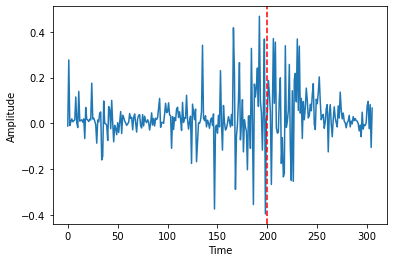

In [5]:
tlb, tub = [187,493]

plt.plot(np.arange(0,306),NSconcat.V[tlb:tub,50,2])
plt.axvline(200, linestyle='--',c='red')
#plt.xlim(200,220)
plt.xlabel('Time')
plt.ylabel('Amplitude')

# PEAK for freq #36 at timestamp 208
# Each freq has a different curve and peak

(-20.0, 20.0)

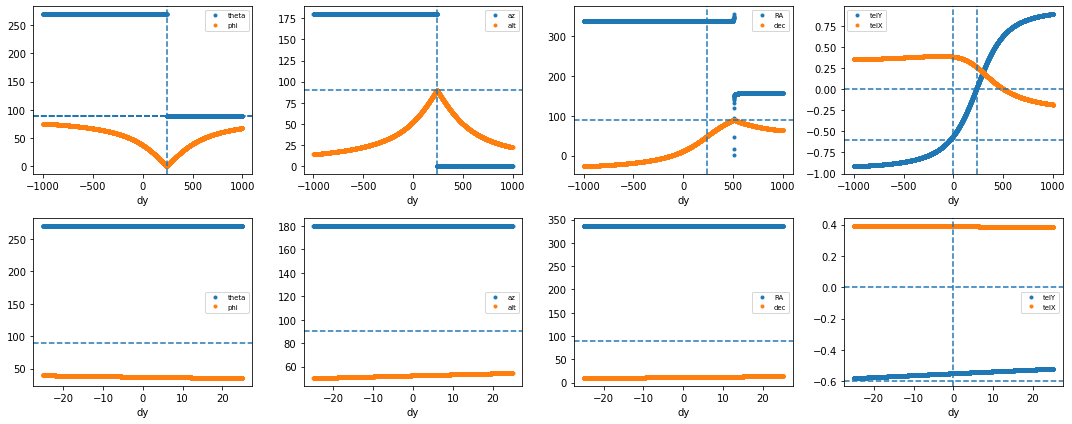

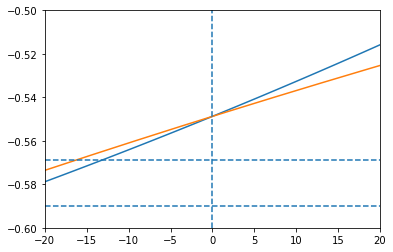

In [3]:
# From Will's code, shouldnt be the same because time is different
## Cartesian to RA/Dec

## Import auxilary packages:
from astropy.coordinates import EarthLocation,SkyCoord
from astropy.time import Time
from astropy import units as u
from astropy.coordinates import AltAz
import astropy.coordinates as coord

## Define cartesian displacement/movement values for dy and dz:
dx0,dy0,dz0=[np.zeros(5000),np.linspace(-1000,1000,5000),np.zeros(5000)]
dx1,dy1,dz1=[np.zeros(5000),np.zeros(5000),np.linspace(-25,25,5000)]
drtp0=np.array([gu.xyz_to_rpt((dx0[j],dy0[j]-239.52,dz0[j]+312.52)) for j in range(5000)])
drtp1=np.array([gu.xyz_to_rpt((dx1[j],dy1[j]-239.52,dz1[j]+312.52)) for j in range(5000)])

## Convert to Alt,Az:
dAz0=drtp0[:,1]-(np.pi/2.0)
dAlt0=(np.pi/2.0)-drtp0[:,2]
dAz1=drtp1[:,1]-(np.pi/2.0)
dAlt1=(np.pi/2.0)-drtp1[:,2]

## Convert to RA/Dec:
tempdat0=SkyCoord(alt=dAlt0*u.rad,\
                 az=dAz0*u.rad,\
                 frame='altaz',\
                 obstime=datetime.datetime.strptime("10/28/22 00:00:00", '%m/%d/%y %H:%M:%S').astimezone(pytz.utc),\
                 location=EarthLocation(lat='49.32070922',lon='-119.62367743',height=555.372*u.m)).transform_to(coord.ICRS)
dRA0=np.array(tempdat0.transform_to(coord.ICRS).ra)
dDec0=np.array(tempdat0.transform_to(coord.ICRS).dec)

tempdat1=SkyCoord(alt=dAlt1*u.rad,\
                 az=dAz1*u.rad,\
                 frame='altaz',\
                 obstime=datetime.datetime.strptime("10/28/22 00:00:00", '%m/%d/%y %H:%M:%S').astimezone(pytz.utc),\
                 location=EarthLocation(lat='49.32070922',lon='-119.62367743',height=555.372*u.m)).transform_to(coord.ICRS)
dRA1=np.array(tempdat1.transform_to(coord.ICRS).ra)
dDec1=np.array(tempdat1.transform_to(coord.ICRS).dec)

## Convert to TelX,TelY:
dtY0,dtX0=telescopeCoords(dRA0,dDec0)
dtY1,dtX1=telescopeCoords(dRA1,dDec1)

## Plot:
fig,[[ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8]]=subplots(nrows=2,ncols=4,figsize=(15,6))
# ax1.plot(dy0,drtp0[:,0])

ax1.plot(dy0,(180.0/np.pi)*drtp0[:,1],'.',label='theta')
ax1.plot(dy0,(180.0/np.pi)*drtp0[:,2],'.',label='phi')
ax1.axhline(90,linestyle='dashed')
ax2.plot(dy0,(180.0/np.pi)*dAz0,'.',label='az')
ax2.plot(dy0,(180.0/np.pi)*dAlt0,'.',label='alt')
ax2.axhline(90,linestyle='dashed')
ax3.plot(dy0,dRA0,'.',label='RA')
ax3.plot(dy0,dDec0,'.',label='dec')
ax3.axhline(90,linestyle='dashed')
ax4.plot(dy0,dtY0,'.',label='telY')
ax4.plot(dy0,dtX0,'.',label='telX')
ax4.axhline(-0.6,linestyle='dashed')
ax4.axvline(0.0,linestyle='dashed')
ax4.axhline(0.0,linestyle='dashed')
for ax in [ax1,ax2,ax3,ax4]:
    ax.axvline(239.52,linestyle='dashed')
    ax1.axhline(90,linestyle='dashed')
    ax.set_xlabel('dy')
    ax.legend(fontsize='x-small')
tight_layout()

ax5.plot(dz1,(180.0/np.pi)*drtp1[:,1],'.',label='theta')
ax5.plot(dz1,(180.0/np.pi)*drtp1[:,2],'.',label='phi')
ax5.axhline(90,linestyle='dashed')
ax6.plot(dz1,(180.0/np.pi)*dAz1,'.',label='az')
ax6.plot(dz1,(180.0/np.pi)*dAlt1,'.',label='alt')
ax6.axhline(90,linestyle='dashed')
ax7.plot(dz1,dRA1,'.',label='RA')
ax7.plot(dz1,dDec1,'.',label='dec')
ax7.axhline(90,linestyle='dashed')
ax8.plot(dz1,dtY1,'.',label='telY')
ax8.plot(dz1,dtX1,'.',label='telX')
ax8.axhline(-0.6,linestyle='dashed')
ax8.axvline(0.0,linestyle='dashed')
ax8.axhline(0.0,linestyle='dashed')
for ax in [ax5,ax6,ax7,ax8]:
#     ax.axvline(-302.52-9.7,linestyle='dashed')
#     ax1.axhline(90,linestyle='dashed')
    ax.set_xlabel('dy')
    ax.legend(fontsize='x-small')
tight_layout()

figure()
plot(dy0,dtY0)
plot(dz1,dtY1)
axhline(-0.59,linestyle='dashed')
axhline(-0.59+.021,linestyle='dashed')
axvline(0.0,linestyle='dashed')
axhline(0.0,linestyle='dashed')
axvline(239.52,linestyle='dashed')
ylim(-0.6,-0.5)
xlim(-20,20)

(0.0, 50.0)

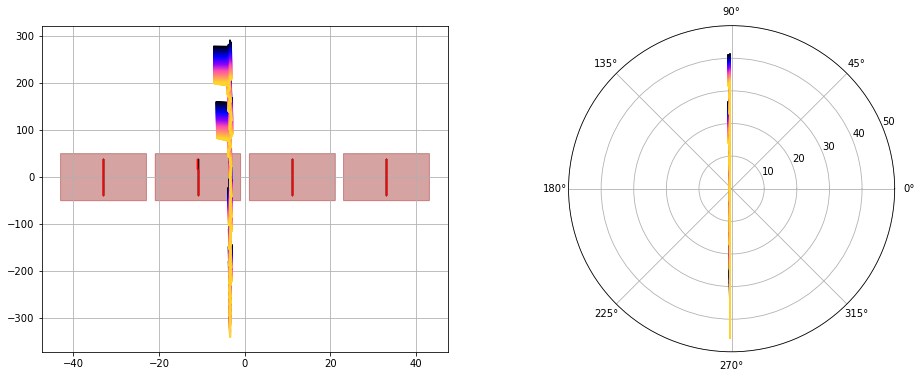

In [4]:

fig=figure(figsize=(16,6))
ax0=fig.add_subplot(121)
ax1=fig.add_subplot(122,projection='polar')
ax0.plot(NSconcat.drone_xyz_per_dish_interp[:,-11,0],NSconcat.drone_xyz_per_dish_interp[:,-11,1])
#ax1.plot(NSconcat.drone_rpt_r_per_dish_interp[-11,197:494,1],NSconcat.drone_rpt_r_per_dish_interp[-11,197:494,2])

for j in [-33,-11,11,33]:
    x=np.array([j-10,j+10])
    y1=np.array([-50,-50])
    y2=np.array([50,50])
    ax0.fill_between(x,y1,y2,color='k',alpha=0.2)
    x0,y10=CHIME_2d_Rot(x,y1)
    x0,y20=CHIME_2d_Rot(x,y2)
    ax0.fill_between(x0,y10,y20,color='r',alpha=0.2)
    xf=j*np.ones(256)
    yf=np.linspace(-0.3048*(256/2),+0.3048*(256/2),256)
    xf0,yf0=CHIME_2d_Rot(xf,yf)
    ax0.plot(xf,yf,'k.',markersize=0.5)
    ax0.plot(xf0,yf0,'r.',markersize=0.5)
ax0.grid()

colorsarr=cm.gnuplot2(np.linspace(0,1,306))

tlb, tub = [207,493]
for j in range(255):
    ax0.plot(NSconcat.drone_xyz_per_dish_interp[j,tlb:tub,0],NSconcat.drone_xyz_per_dish_interp[j,tlb:tub,1],c=colorsarr[j])
    ax1.plot(NSconcat.drone_rpt_r_per_dish_interp[j,tlb:tub,1],(180.0/np.pi*NSconcat.drone_rpt_r_per_dish_interp[j,tlb:tub,2]),c=colorsarr[j])
ax1.set_rlim(0,50)

#ax0.set_xlim(-50,50)

In [8]:
tlb, tub = [187, 493]
for j in range(255):
    print(f'j = {j}')
    print(f'x0: {NSconcat.drone_xyz_per_dish_interp[j, tlb:tub, 0]}')
    print(f'y0: {NSconcat.drone_xyz_per_dish_interp[j, tlb:tub, 1]}')
    print(f'x1: {NSconcat.drone_rpt_r_per_dish_interp[j, tlb:tub, 1]}')
    print(f'y1: {(180.0 / np.pi * NSconcat.drone_rpt_r_per_dish_interp[j, tlb:tub, 2])}')
    ax0.plot(NSconcat.drone_xyz_per_dish_interp[j, tlb:tub, 0], 
             NSconcat.drone_xyz_per_dish_interp[j, tlb:tub, 1], 
             c=colorsarr[j])
    ax1.plot(NSconcat.drone_rpt_r_per_dish_interp[j, tlb:tub, 1], 
             (180.0 / np.pi * NSconcat.drone_rpt_r_per_dish_interp[j, tlb:tub, 2]), 
             c=colorsarr[j])
ax1.set_rlim(0, 50)


j = 0
x0: [-2.68312499 -2.11568232 -2.75600293 -3.13839773 -3.24411164 -3.13555643
 -3.30667819 -3.32494876 -3.18274905 -3.22796608 -3.53277644 -3.7314129
 -3.40265169 -3.12799098 -3.13228653 -3.09633991 -3.14516742 -3.23233072
 -3.2153228  -3.30384521 -3.41818919 -3.47605027 -3.15612304 -3.26338535
 -3.48117234 -3.80216154 -3.71979426 -3.7266002  -7.23914816 -7.14000743
 -3.84572442 -3.66167418 -3.56066942 -3.68528706 -3.62312926 -3.64914912
 -3.88733541 -4.19719616 -4.26606212 -4.25802098 -4.00288039 -4.0636494
 -4.02288796 -3.74356266 -3.48841551 -3.48554309 -3.36145067 -3.28409043
 -3.52631776 -3.75744519 -3.69001116 -3.56895868 -3.58021927 -3.4499453
 -3.73853994 -3.78630086 -3.98824132 -3.9657052  -3.8384649  -3.34971875
 -3.25108375 -3.38723047 -3.39091706 -3.25008985 -3.37930222 -3.34404441
 -3.25988815 -3.20597577 -3.14640871 -3.31037927 -3.39307377 -3.36840464
 -3.51835611 -3.50889467 -3.57733341 -3.39192462 -3.55001032 -3.65879846
 -3.61664451 -3.3714283  -3.43319249 -3.3993

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [8]:
print(NSconcat.drone_rpt_r_per_dish_interp.shape)
print(NSconcat.drone_xyz_per_dish_interp.shape)

(512, 768, 3)
(512, 768, 3)


In [4]:
print(NSconcat.drone_xyz_per_dish_interp[127+256,:,2].shape)

(768,)


Star coordinates: x = 575, y = 16.494472039140938


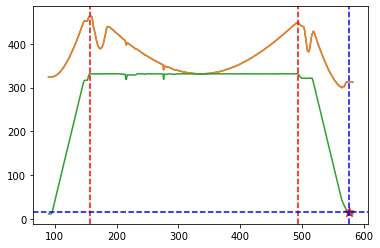

In [16]:
plot(np.array([gu.xyz_to_rpt(k) for k in NSconcat.drone_xyz_per_dish_interp[127,:,:]])[:,0])
plot(NSconcat.drone_rpt_r_per_dish_interp[127+256,:,0])
plot(NSconcat.drone_xyz_per_dish_interp[127+256,:,2])
plt.axvline(157,c='red',linestyle='--')
plt.axvline(494,c='red',linestyle='--')
plt.axhline(15,c='blue',linestyle='--')
plt.axvline(575,c='blue',linestyle='--')
plt.scatter(575, np.interp(575, np.arange(NSconcat.drone_xyz_per_dish_interp.shape[1]), NSconcat.drone_xyz_per_dish_interp[127+256,:,2]), color='red', marker='*', s=100, label='Star')
y_star = np.interp(575, np.arange(NSconcat.drone_xyz_per_dish_interp.shape[1]), NSconcat.drone_xyz_per_dish_interp[127+256,:,2])
print(f"Star coordinates: x = 575, y = {y_star}")

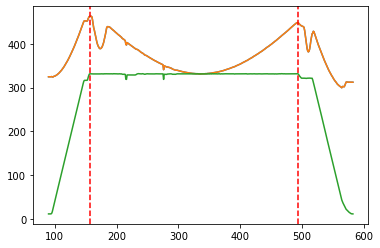

In [7]:
plot(np.array([gu.xyz_to_rpt(k) for k in NSconcat.drone_xyz_per_dish_interp[127,:,:]])[:,0])
plot(NSconcat.drone_rpt_r_per_dish_interp[127,:,0])
plot(NSconcat.drone_xyz_per_dish_interp[127,:,2])
plt.axvline(157,c='red',linestyle='--')
plt.axvline(494,c='red',linestyle='--')

In [30]:
print(NSconcat.drone_rpt_r_per_dish_interp.shape)
print(NSconcat.drone_rpt_r_per_dish_interp.shape[0])
print(NSconcat.drone_rpt_r_per_dish_interp.shape[1],2)
print(RA_m.shape)

(512, 768, 3)
512
768 2
(306, 768)


In [29]:
print(NSconcat.drone_rpt_r_per_dish_interp[255:511,:,:].shape[0])

256


/home/ec2274/anaconda3/lib/python3.8/site-packages/erfa/core.py:4334: RuntimeWarning: invalid value encountered in atoiq
  ri, di = ufunc.atoiq(type, ob1, ob2, astrom)
/home/ec2274/anaconda3/lib/python3.8/site-packages/erfa/core.py:4431: RuntimeWarning: invalid value encountered in ld
  p1 = ufunc.ld(bm, p, q, e, em, dlim)


(512, 768, 2)
158.07929647747974
Subtracting median RA value of: 213.82139179337423deg
-0.6427876096865393 -0.49999999999999994


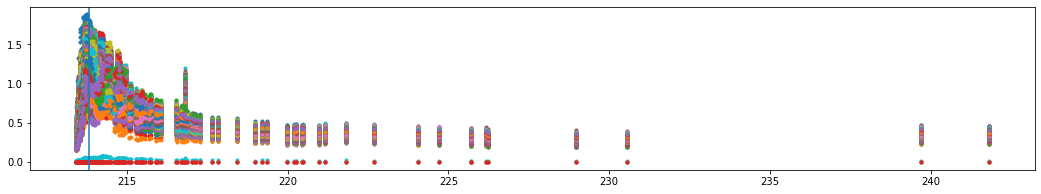

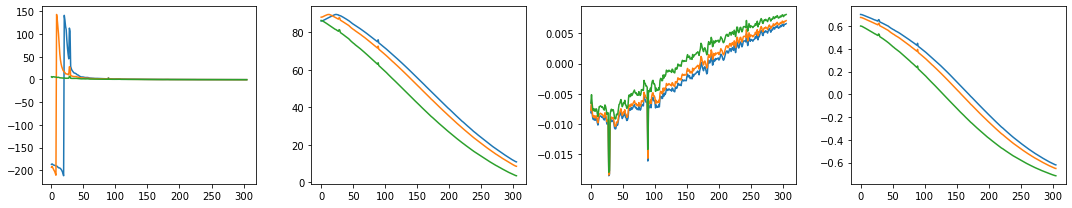

In [5]:
tlb, tub = [207,493]

RA_Dec_per_feed=np.zeros(((NSconcat.drone_rpt_r_per_dish_interp.shape[0],NSconcat.drone_rpt_r_per_dish_interp.shape[1],2))) #(feed number, angle, 2)
RA_Dec_per_feed.shape

Az=NSconcat.drone_rpt_r_per_dish_interp[:,:,1]-(np.pi/2.0)
Alt=(np.pi/2.0)-NSconcat.drone_rpt_r_per_dish_interp[:,:,2]
Az_m=Az
Alt_m=Alt
#Masking Nan values
Az_m[np.isnan(Az)]=Az[0,767]
Az_m[np.where(Alt>(np.pi/2.0))]=Az[0,767]
Alt_m[np.isnan(Alt)]=Alt[0,767]
Alt_m[np.where(Alt>(np.pi/2.0))]=Alt[0,767]

dat=SkyCoord(alt=Alt_m*u.rad,\
             az=Az_m*u.rad,\
             frame='altaz',\
             obstime=NSconcat.t_arr_datetime[157],\
             #obstime=datetime.datetime.strptime("10/28/22 00:00:00", '%m/%d/%y %H:%M:%S'),\
             location=EarthLocation(lat='49.32070922',lon='-119.62367743',height=555.372*u.m)).transform_to(coord.ICRS)


RA_m=np.array(dat.transform_to(coord.ICRS).ra)
#RA_m[np.isnan(Az)]=np.nan
Dec_m=np.array(dat.transform_to(coord.ICRS).dec)
#Dec_m[np.isnan(Az)]=np.nan
RA_Dec_per_feed[:,:,0]=RA_m[:,:]
RA_Dec_per_feed[:,:,1]=Dec_m[:,:]
print(RA_Dec_per_feed.shape)
print(RA_Dec_per_feed[75,157,0])

mediansubRA=np.nan*np.ones((2,len(np.arange(100,150)),len(np.arange(0,1024,35))))


tlb,tub=[207,493]
for j,feed in enumerate(np.arange(100,150)):
    for k,ff in enumerate(np.arange(0,1024,35)):
        try:
            ## doing things in TelX,TelY:
            input_data=np.array([RA_Dec_per_feed[feed,tlb:tub,0],NSconcat.V[tlb:tub,ff,feed]])
            pG=[1.0,np.nanmedian(RA_Dec_per_feed[feed,tlb:tub,0]),3.0,0.01]
            G_popt = least_squares(Gauss_opt,x0=pG,method='trf',args=input_data).x
            mediansubRA[0,j,k]=G_popt[1]
        except (RuntimeError, np.linalg.LinAlgError):   
            pass


fig, ax1=subplots(nrows=1,ncols=1,figsize=(18,3))
tlb,tub=[207,493]
ax1.plot(RA_Dec_per_feed[75, tlb:tub, 0], np.nanmean(NSconcat.V[tlb:tub, :, 256:-1], axis=1), '.')
ax1.axvline(np.nanmedian(mediansubRA[0,:,:]))
print("Subtracting median RA value of: {}deg".format(np.nanmedian(mediansubRA[0,:,:])))
RA_Dec_per_feed[:,:,0]=RA_m-np.nanmedian(mediansubRA[0,:,:])


telXY_per_feed=np.NaN*np.ones(RA_Dec_per_feed.shape)
for k in range(RA_Dec_per_feed.shape[0]):
    telXY_per_feed[k,:,1],telXY_per_feed[k,:,0]=telescopeCoords(RA_Dec_per_feed[k,:,0],RA_Dec_per_feed[k,:,1])


fig,[ax0,ax1,ax2,ax3]=subplots(nrows=1,ncols=4,figsize=(15,3))
for fd in [0,75,255+256]:
    ax0.plot(RA_Dec_per_feed[fd,187:493,0])
    ax1.plot(RA_Dec_per_feed[fd,187:493,1])
    ax2.plot(telXY_per_feed[fd,187:493,0])
    ax3.plot(telXY_per_feed[fd,187:493,1])
tight_layout()

print(np.sin(-40/180*np.pi),np.sin(-30/180*np.pi))

In [60]:
print(NSconcat.drone_xyz_per_dish_interp.shape)

(512, 768, 3)


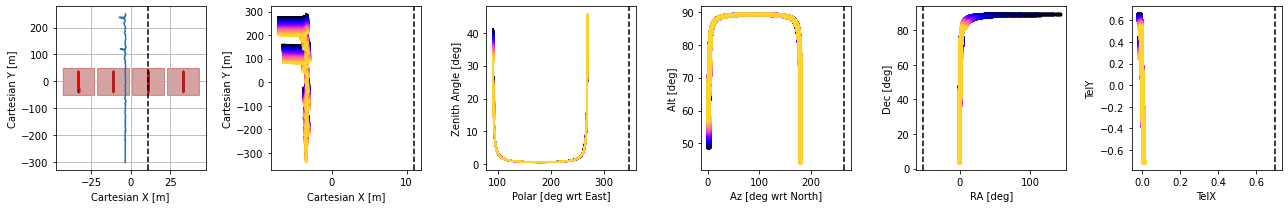

In [18]:
fig,[ax0,ax1,ax2,ax3,ax4,ax5]=subplots(nrows=1,ncols=6,figsize=(18,3))
tight_layout()

tlb, tub = [207,493]

ax0.plot(NSconcat.drone_xyz_per_dish_interp[127+256,tlb:tub,0],NSconcat.drone_xyz_per_dish_interp[127+256,tlb:tub,1])
#ax0.plot(NSconcat.drone_xyz_per_dish_interp[127+256,157,0],NSconcat.drone_xyz_per_dish_interp[127+256,157,1],'ro')
for j in [-33,-11,11,33]:
    x=np.array([j-10,j+10])
    y1=np.array([-50,-50])
    y2=np.array([50,50])
    ax0.fill_between(x,y1,y2,color='k',alpha=0.2)
    x0,y10=CHIME_2d_Rot(x,y1)
    x0,y20=CHIME_2d_Rot(x,y2)
    ax0.fill_between(x0,y10,y20,color='r',alpha=0.2)
    xf=j*np.ones(256)
    yf=np.linspace(-0.3048*(256/2),+0.3048*(256/2),256)
    xf0,yf0=CHIME_2d_Rot(xf,yf)
    ax0.plot(xf,yf,'k.',markersize=0.5)
    ax0.plot(xf0,yf0,'r.',markersize=0.5)
ax0.grid()

for tbds in [[207,493]]:
    tlb,tub=tbds
    for feedind in range(255):
        ax1.plot(NSconcat.drone_xyz_per_dish_interp[feedind,tlb:tub,0],NSconcat.drone_xyz_per_dish_interp[feedind,tlb:tub,1],c=colorsarr[feedind])
        ax2.plot(180.0/np.pi*NSconcat.drone_rpt_r_per_dish_interp[feedind,tlb:tub,1],(180.0/np.pi*NSconcat.drone_rpt_r_per_dish_interp[feedind,tlb:tub,2]),c=colorsarr[feedind])
        
        ax3.plot((180/np.pi)*Az[feedind,tlb:tub],(180/np.pi)*Alt[feedind,tlb:tub],'.-',c=colorsarr[feedind])
        ax4.plot(RA_Dec_per_feed[feedind,tlb:tub,0],RA_Dec_per_feed[feedind,tlb:tub,1],'.-',c=colorsarr[feedind])
        ax5.plot(telXY_per_feed[feedind,tlb:tub,0],telXY_per_feed[feedind,tlb:tub,1],'.-',c=colorsarr[feedind])

xlabels=("Cartesian X [m]","Cartesian X [m]","Polar [deg wrt East]","Az [deg wrt North]","RA [deg]","TelX")
ylabels=("Cartesian Y [m]","Cartesian Y [m]","Zenith Angle [deg]","Alt [deg]","Dec [deg]","TelY")

ax0.axvline(11,color='k',linestyle='dashed')
ax1.axvline(11,color='k',linestyle='dashed')
ax2.axvline(180.0/np.pi*NSconcat.drone_rpt_r_per_dish_interp[feedind,157,1],color='k',linestyle='dashed')
ax3.axvline(180.0/np.pi*Az[127,157],color='k',linestyle='dashed')
ax4.axvline(RA_Dec_per_feed[feedind,157,0],color='k',linestyle='dashed')
ax5.axvline(telXY_per_feed[feedind,157,0],color='k',linestyle='dashed')

#ax2.set_ylim(42,29)

for i,ax in enumerate([ax0,ax1,ax2,ax3,ax4,ax5]):
    ax.set_xlabel(xlabels[i])
    ax.set_ylabel(ylabels[i])
tight_layout()

In [ ]:
# There was a singularity at ~90 dec. Changing the lower time bound (tlb) fix it. Sorry if I didn't change tlb everywhere. It should be 207, instead of 187

In [ ]:
for j in range(255):
    ax0.plot(NSconcat.drone_xyz_per_dish_interp[j,tlb:tub,0],NSconcat.drone_xyz_per_dish_interp[j,tlb:tub,1],c=colorsarr[j])
    ax1.plot(NSconcat.drone_rpt_r_per_dish_interp[j,tlb:tub,1],(180.0/np.pi*NSconcat.drone_rpt_r_per_dish_interp[j,tlb:tub,2]),c=colorsarr[j])

158.07929647747974
Subtracting median RA value of: 214.00478403867606deg
-0.6427876096865393 -0.49999999999999994


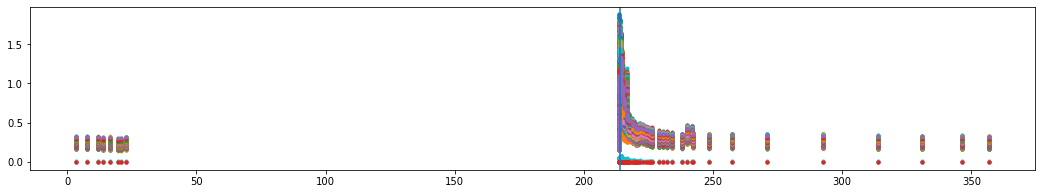

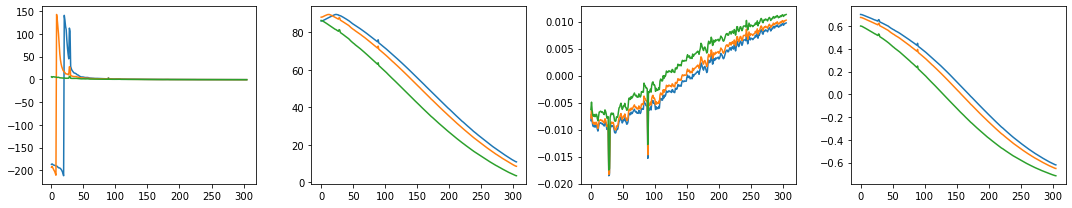

In [24]:
'''
RA_Dec_per_feed=np.zeros((NSconcat.drone_rpt_r_per_dish_interp.shape[0],NSconcat.drone_rpt_r_per_dish_interp.shape[1],2))
RA_Dec_per_feed.shape

Az=NSconcat.drone_rpt_r_per_dish_interp[:,:,1]-(np.pi/2.0)
Alt=(np.pi/2.0)-NSconcat.drone_rpt_r_per_dish_interp[:,:,2]
Az_m=Az
Alt_m=Alt
#Masking Nan values
Az_m[np.isnan(Az)]=Az[187,493]
Az_m[np.where(Alt>(np.pi/2.0))]=Az[187,493]
Alt_m[np.isnan(Alt)]=Alt[187,493]
Alt_m[np.where(Alt>(np.pi/2.0))]=Alt[187,493]

dat=SkyCoord(alt=Alt_m*u.rad,\
             az=Az_m*u.rad,\
             frame='altaz',\
             obstime=NSconcat.t_arr_datetime[157],\
             #obstime=datetime.datetime.strptime("10/28/22 00:00:00", '%m/%d/%y %H:%M:%S'),\
             location=EarthLocation(lat='49.32070922',lon='-119.62367743',height=555.372*u.m)).transform_to(coord.ICRS)


RA_m=np.array(dat.transform_to(coord.ICRS).ra)
RA_m[np.isnan(Az)]=np.nan
Dec_m=np.array(dat.transform_to(coord.ICRS).dec)
Dec_m[np.isnan(Az)]=np.nan
RA_Dec_per_feed[:,:,0]=RA_m
RA_Dec_per_feed[:,:,1]=Dec_m
print(RA_Dec_per_feed[75,157,0])

mediansubRA=np.nan*np.ones((2,len(np.arange(100,150)),len(np.arange(0,1024,35))))

tlb,tub=[187,493]
for j,feed in enumerate(np.arange(100+256,150+256)):
    for k,ff in enumerate(np.arange(0,1024,35)):
        try:
            ## doing things in TelX,TelY:
            input_data=np.array([RA_Dec_per_feed[feed,tlb:tub,0],NSconcat.V[tlb:tub,ff,feed]])
            pG=[1.0,np.nanmedian(RA_Dec_per_feed[feed,tlb:tub,0]),3.0,0.01]
            G_popt = least_squares(Gauss_opt,x0=pG,method='trf',args=input_data).x
            mediansubRA[0,j,k]=G_popt[1]
        except (RuntimeError, np.linalg.LinAlgError):   
            pass

fig, ax1=subplots(nrows=1,ncols=1,figsize=(18,3))
tlb,tub=[187,493]
ax1.plot(RA_Dec_per_feed[75, tlb:tub, 0], np.nanmean(NSconcat.V[tlb:tub, :, 256:-1], axis=1), '.')
ax1.axvline(np.nanmedian(mediansubRA[0,:,:]))
print("Subtracting median RA value of: {}deg".format(np.nanmedian(mediansubRA[0,:,:])))
RA_Dec_per_feed[:,:,0]=RA_m-np.nanmedian(mediansubRA[0,:,:])


telXY_per_feed=np.NaN*np.ones(RA_Dec_per_feed.shape)
for k in range(RA_Dec_per_feed.shape[0]):
    telXY_per_feed[k,:,1],telXY_per_feed[k,:,0]=telescopeCoords(RA_Dec_per_feed[k,:,0],RA_Dec_per_feed[k,:,1])

fig,[ax0,ax1,ax2,ax3]=subplots(nrows=1,ncols=4,figsize=(15,3))
for fd in [0,75,255+256]:
    ax0.plot(RA_Dec_per_feed[fd,187:493,0])
    ax1.plot(RA_Dec_per_feed[fd,187:493,1])
    ax2.plot(telXY_per_feed[fd,187:493,0])
    ax3.plot(telXY_per_feed[fd,187:493,1])
tight_layout()

print(np.sin(-40/180*np.pi),np.sin(-30/180*np.pi))
'''

In [18]:
print(Az[100,600])

3.130142634552625


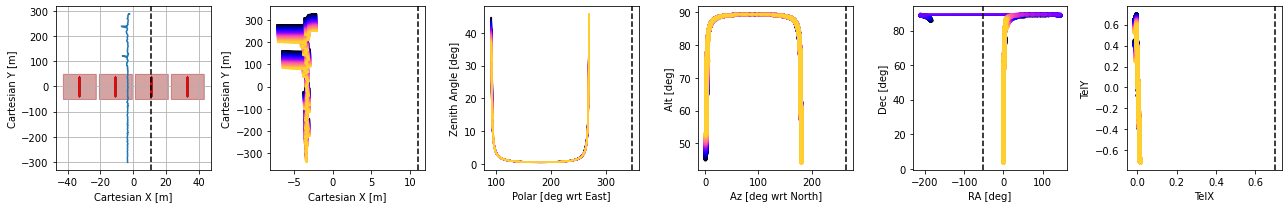

In [26]:
'''
fig,[ax0,ax1,ax2,ax3,ax4,ax5]=subplots(nrows=1,ncols=6,figsize=(18,3))
tight_layout()

ax0.plot(NSconcat.drone_xyz_per_dish_interp[127+256,187:493,0],NSconcat.drone_xyz_per_dish_interp[127+256,187:493,1])
#ax0.plot(NSconcat.drone_xyz_per_dish_interp[127+256,157,0],NSconcat.drone_xyz_per_dish_interp[127+256,157,1],'ro')
for j in [-33,-11,11,33]:
    x=np.array([j-10,j+10])
    y1=np.array([-50,-50])
    y2=np.array([50,50])
    ax0.fill_between(x,y1,y2,color='k',alpha=0.2)
    x0,y10=CHIME_2d_Rot(x,y1)
    x0,y20=CHIME_2d_Rot(x,y2)
    ax0.fill_between(x0,y10,y20,color='r',alpha=0.2)
    xf=j*np.ones(256)
    yf=np.linspace(-0.3048*(256/2),+0.3048*(256/2),256)
    xf0,yf0=CHIME_2d_Rot(xf,yf)
    ax0.plot(xf,yf,'k.',markersize=0.5)
    ax0.plot(xf0,yf0,'r.',markersize=0.5)
ax0.grid()

for tbds in [[187,493]]:
    tlb,tub=tbds
    for feedind in np.arange(0,256,4):
        ax1.plot(NSconcat.drone_xyz_per_dish_interp[feedind,tlb:tub,0],NSconcat.drone_xyz_per_dish_interp[feedind,tlb:tub,1],c=colorsarr[feedind])
        ax2.plot(180.0/np.pi*NSconcat.drone_rpt_r_per_dish_interp[feedind,tlb:tub,1],(180.0/np.pi*NSconcat.drone_rpt_r_per_dish_interp[feedind,tlb:tub,2]),c=colorsarr[feedind])
        
        ax3.plot((180/np.pi)*Az[feedind,tlb:tub],(180/np.pi)*Alt[feedind,tlb:tub],'.-',c=colorsarr[feedind])
        ax4.plot(RA_Dec_per_feed[feedind,tlb:tub,0],RA_Dec_per_feed[feedind,tlb:tub,1],'.-',c=colorsarr[feedind])
        ax5.plot(telXY_per_feed[feedind,tlb:tub,0],telXY_per_feed[feedind,tlb:tub,1],'.-',c=colorsarr[feedind])

xlabels=("Cartesian X [m]","Cartesian X [m]","Polar [deg wrt East]","Az [deg wrt North]","RA [deg]","TelX")
ylabels=("Cartesian Y [m]","Cartesian Y [m]","Zenith Angle [deg]","Alt [deg]","Dec [deg]","TelY")

ax0.axvline(11,color='k',linestyle='dashed')
ax1.axvline(11,color='k',linestyle='dashed')
ax2.axvline(180.0/np.pi*NSconcat.drone_rpt_r_per_dish_interp[feedind,157,1],color='k',linestyle='dashed')
ax3.axvline(180.0/np.pi*Az[127,157],color='k',linestyle='dashed')
ax4.axvline(RA_Dec_per_feed[feedind,157,0],color='k',linestyle='dashed')
ax5.axvline(telXY_per_feed[feedind,157,0],color='k',linestyle='dashed')

#ax2.set_ylim(42,29)

for i,ax in enumerate([ax0,ax1,ax2,ax3,ax4,ax5]):
    ax.set_xlabel(xlabels[i])
    ax.set_ylabel(ylabels[i])
tight_layout()
'''

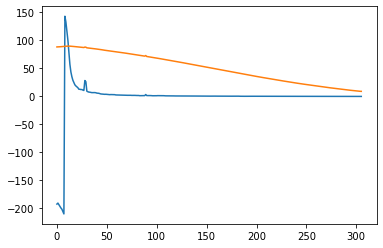

In [65]:
plt.plot(RA_Dec_per_feed[331,tlb:tub,0])
plt.plot(RA_Dec_per_feed[331,tlb:tub,1])
plt.show()

In [44]:
print(Dec_m.shape) #feed, Dec

(512, 768)


In [32]:
tlb, tub = [207,493]
print((RA_Dec_per_feed[tlb:tub,:,0])[0].shape)
print((NSconcat.V[tlb:tub,:,75+256])[1].shape)
print('.')
print((RA_Dec_per_feed[:,:,0]).shape)
print((NSconcat.V[tlb:tub,:,75+256]).shape)
print('.')
print((RA_Dec_per_feed[:,:,:]).shape) #time, RA/Dec value, RA/Dec
print((NSconcat.V[tlb:tub,:,:]).shape)

(768,)
(1024,)
.
(306, 768)
(306, 1024)
.
(306, 768, 2)
(306, 1024, 512)


In [ ]:
print(NSconcat.V[tlb:tub,:,75+256].shape[)

TypeError: pcolormesh() takes 1 or 3 positional arguments but 2 were given

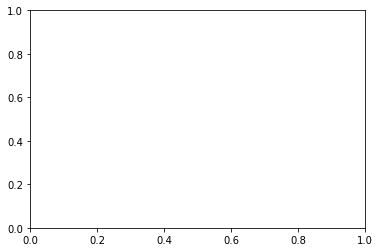

In [6]:
plt.pcolormesh(RA_Dec_per_feed[tlb:tub, :, 1], RA_Dec_per_feed[tlb:tub, :, 0], cmap='gnuplot2')

In [18]:
print(NSconcat.freq)
print(Dec_m[255:511, tlb:tub].shape)

[800.       799.609375 799.21875  ... 401.171875 400.78125  400.390625]
(256, 286)


256


In [67]:
freqIndList = np.linspace(0, len(NSconcat.freq)-1, 256, dtype=int)
freqList = NSconcat.freq[freqIndList]
print(freqList.shape)
print(freqList)

(256,)
[800.       798.4375   796.875    795.3125   793.75     792.1875
 790.625    789.0625   787.5      785.9375   784.375    782.8125
 781.25     779.6875   778.125    776.5625   775.       773.4375
 771.875    770.3125   768.75     767.1875   765.625    764.0625
 762.5      760.9375   759.375    757.8125   756.25     754.6875
 753.125    751.5625   750.       748.4375   746.875    745.3125
 743.75     742.1875   740.625    739.0625   737.5      735.9375
 734.375    732.8125   731.25     729.6875   728.125    726.5625
 725.       723.4375   721.875    720.3125   718.75     717.1875
 715.625    714.0625   712.5      710.9375   709.375    707.8125
 706.25     704.6875   703.125    701.5625   700.       698.4375
 696.875    695.3125   693.75     692.1875   690.625    689.0625
 687.5      685.9375   684.375    682.8125   681.25     679.6875
 678.125    676.5625   675.       673.4375   671.875    670.3125
 668.75     666.796875 665.234375 663.671875 662.109375 660.546875
 658.984375 657.

(286, 1024)
(286,)
(286, 1024)


<ipython-input-95-7d695bb612e1>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(np.arange(NSconcatDec.shape[1]), decVal, NSconcatDec)


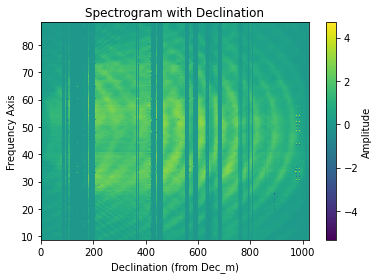

In [95]:
subarray = NSconcat.V[tlb:tub,:,75+256]
decVal = Dec_m[255+75, tlb:tub]

print(subarray.shape)
print(decVal.shape)

NSconcatDec = np.empty_like(subarray, dtype=float)
for i in range(NSconcatDec.shape[0]):
    NSconcatDec[i]=subarray[i]
    
print(NSconcatDec.shape)


<ipython-input-98-e7beb261622d>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(np.arange(subarray.shape[1]), np.arange(subarray.shape[0]), subarray)


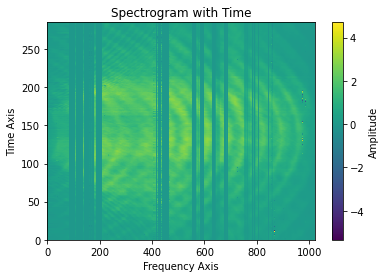

<ipython-input-98-e7beb261622d>:10: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(np.arange(NSconcatDec.shape[1]), decVal, NSconcatDec, shading='auto')


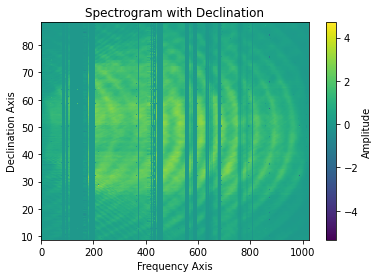

In [98]:
plt.figure()
plt.pcolormesh(np.arange(subarray.shape[1]), np.arange(subarray.shape[0]), subarray)
plt.xlabel('Frequency Axis')
plt.ylabel('Time Axis')
plt.title('Spectrogram with Time')
plt.colorbar(label='Amplitude')
plt.show()

plt.figure()
plt.pcolormesh(np.arange(NSconcatDec.shape[1]), decVal, NSconcatDec, shading='auto')
plt.xlabel('Frequency Axis')
plt.ylabel('Declination Axis')
plt.title('Spectrogram with Declination')
plt.colorbar(label='Amplitude')
plt.show()


In [35]:
print(Dec_m.shape)

(512, 768)


In [87]:
subarray = NSconcat.V[tlb:tub,:,255+75]
decVal = RA_Dec_per_feed[255+75, tlb:tub,1]

print(subarray.shape)
print(decVal.shape)

NSconcatDec = np.empty([286, 1024], dtype=float)
for i in range(NSconcatDec.shape[0]):
    NSconcatDec[i]=subarray[i]
    
print(NSconcatDec.shape)

(286, 1024)
(286,)
(286, 1024)


In [32]:
print(NSconcat.V[tlb,0,255+75])
print(NSconcatDec[255,0])

-0.0001220703125
[ 3.05175781e-05  2.83203125e-02  1.01562500e-01 -1.56250000e-02
  7.32421875e-04  4.88281250e-03  1.31835938e-02  6.34765625e-03
  0.00000000e+00  1.80664062e-02  0.00000000e+00  8.01086426e-05
  9.76562500e-04  3.51562500e-02 -7.62939453e-05  0.00000000e+00
  7.32421875e-04 -4.88281250e-04  0.00000000e+00  0.00000000e+00
 -7.91015625e-02  3.05175781e-05 -9.76562500e-04  0.00000000e+00
 -1.95312500e-03  3.33786011e-05  1.22070312e-03  1.17187500e-02
  5.37109375e-03  0.00000000e+00  5.66406250e-02  1.14440918e-04
 -2.34375000e-02  9.15527344e-05 -4.39453125e-03 -9.53674316e-06
  0.00000000e+00 -7.32421875e-04 -7.32421875e-04  0.00000000e+00
 -6.71386719e-04 -3.05175781e-05 -1.40625000e-01  0.00000000e+00
  4.88281250e-03  1.56250000e-02  0.00000000e+00  0.00000000e+00
 -4.88281250e-04  9.76562500e-04  0.00000000e+00 -8.54492188e-04
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.36718750e-02  0.00000000e+00
  1.8310

In [25]:

# Extract the first axis values (i.e., all elements along the first axis)
DecList = NSconcatDec[:, 0, 0].copy()

# Verify the shape of the new array
print(DecList.shape)
print(DecList)


(286,)
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.40310704e-06
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.40310704e-06  0.00000000e+00
  1.14440918e-05  0.00000000e+00  0.00000000e+00 -1.40310704e-06
  0.00000000e+00 -1.40310704e-06  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.40310704e-06 -1.40310704e-06
  0.00000000e+00  0.00000000e+00  8.58306885e-06 -1.40310704e-06
  0.00000000e+00 -1.40310704e-06  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.40310704e-06  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.40310704e-06  0.00000000e+00 -1.40310704e-06
  0.00000000e+00  0.00000000e+00  8.58306885e-06  0.00000000e+00
  0.00000000e+00 -1.40310704e-06  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.40310704e-06  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -

In [98]:
NSconcatDecList = []
for i in range(NSconcatDec.shape[0]):
    NSconcatDecList.append(NSconcatDec[i,:,:])
NSconcatDecList = np.array(NSconcatDecList)

print(NSconcatDecList.shape)

(286, 1024, 512)


In [53]:
print(Dec_m.shape) #Feed, time/dec
print(NSconcat.V[tlb:tub,:,75+256].shape) #time, freq

(512, 768)
(286, 1024)


In [51]:

array1 = NSconcat.V[tlb:tub,:,75+256]
array2 = Dec_m[:,tlb:tub]

# Compare shapes
shape_match = array1.shape == array2.shape
print(f"Shape match: {shape_match}")

if shape_match:
    # Compare element-wise equality
    values_match = np.array_equal(array1, array2)
    print(f"Values match: {values_match}")
    
    # Calculate the difference
    difference = array1 - array2
    
    # Check if there are any non-zero differences
    if np.any(difference):
        print("Arrays are not identical. Differences found.")
        
        # Print some statistics about the differences
        max_difference = np.max(difference)
        min_difference = np.min(difference)
        mean_difference = np.mean(difference)
        print(f"Max difference: {max_difference}")
        print(f"Min difference: {min_difference}")
        print(f"Mean difference: {mean_difference}")
    else:
        print("Arrays are identical.")
else:
    print("Arrays have different shapes and cannot be compared element-wise.")


Shape match: False
Arrays have different shapes and cannot be compared element-wise.


In [75]:
print(NSconcatDec[:,0].shape)

(286,)


In [7]:
print(NSconcat.V[tlb:tub,:,:].shape)

(286, 1024, 512)


<ipython-input-112-5da6bb685950>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(NSconcat.t_arr_datetime[tlb:tub], NSconcat.freq, np.transpose(NSconcat.V[tlb:tub,:,75+256]), cmap='gnuplot2') #Don't forget to add 256, otherwise you get an empty plot due to wrong polarization
<ipython-input-112-5da6bb685950>:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(RA_Dec_per_feed[255+75, tlb:tub,1], NSconcat.freq, np.transpose(NSconcat.

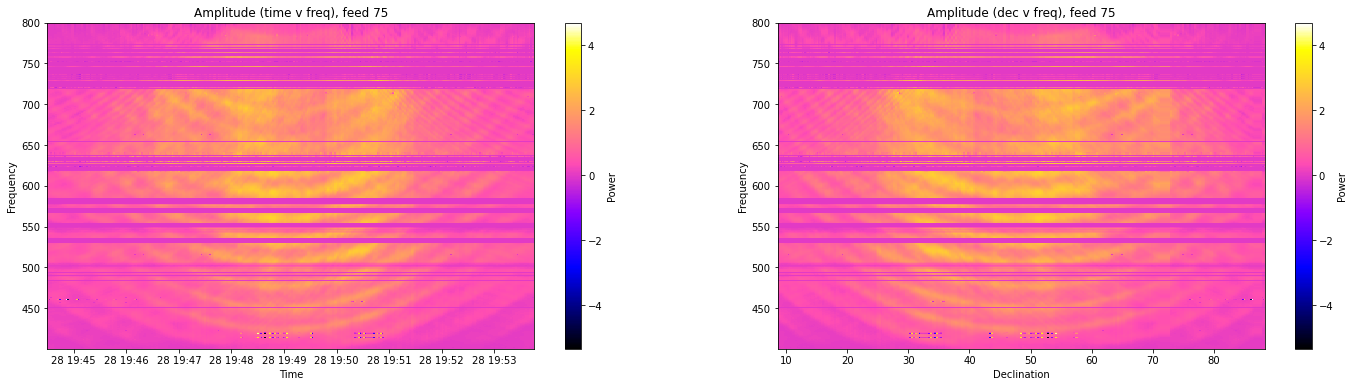

In [112]:
# Plots for the amplitude of the signal at different frequencies. The left plot is in time units and right one in declination
# The might look similar, but they are not!

tlb, tub = [207,493]

plt.figure(figsize=(24, 6))
plt.subplot(1, 2, 1)
plt.pcolormesh(NSconcat.t_arr_datetime[tlb:tub], NSconcat.freq, np.transpose(NSconcat.V[tlb:tub,:,75+256]), cmap='gnuplot2') #Don't forget to add 256, otherwise you get an empty plot due to wrong polarization
plt.colorbar().set_label('Power')
plt.title('Amplitude (time v freq), feed 75')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.subplot(1, 2, 2)
plt.pcolormesh(RA_Dec_per_feed[255+75, tlb:tub,1], NSconcat.freq, np.transpose(NSconcat.V[tlb:tub,:,75+256]), cmap='gnuplot2')
plt.ylabel('Frequency')
plt.xlabel('Declination')
plt.title('Amplitude (dec v freq), feed 75')
plt.colorbar().set_label('Power')
plt.show()

<ipython-input-19-bee1ac8e3ff4>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(NSconcat.t_arr_datetime[tlb:tub], np.arange(256), np.transpose(NSconcat.V[tlb:tub,freqEntNum,255:511]), cmap='gnuplot2') #Don't forget to add 256, otherwise you get an empty plot due to wrong polarization
<ipython-input-19-bee1ac8e3ff4>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(RA_Dec_per_feed[255:511, tlb:tub,1], np.arange(256), np.transpos

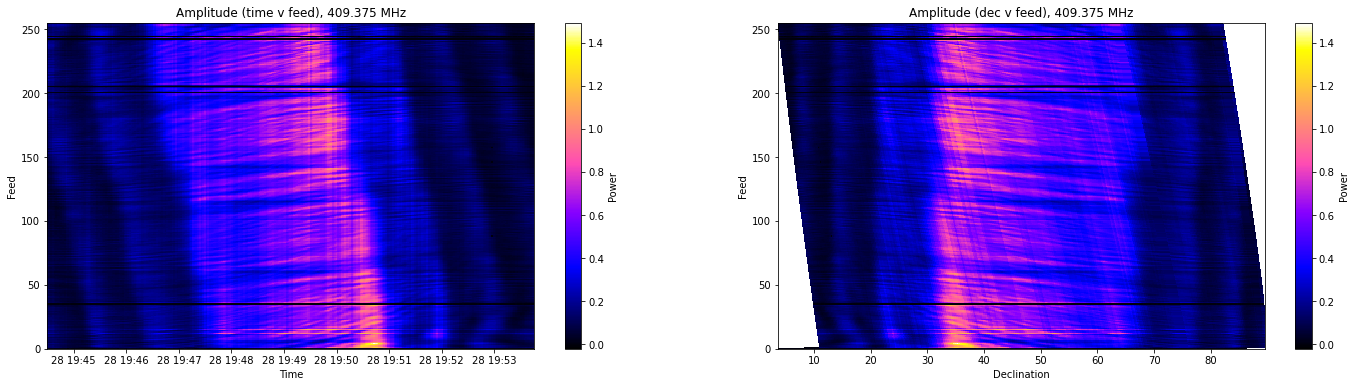

In [19]:
#Same idea as before, but this time the y-axis is feed index number.

tlb, tub = [207,493]

freqEntNum = 1000

plt.figure(figsize=(24, 6))
plt.subplot(1, 2, 1)
plt.pcolormesh(NSconcat.t_arr_datetime[tlb:tub], np.arange(256), np.transpose(NSconcat.V[tlb:tub,freqEntNum,255:511]), cmap='gnuplot2') #Don't forget to add 256, otherwise you get an empty plot due to wrong polarization
plt.colorbar().set_label('Power')
plt.title(f'Amplitude (time v feed), {NSconcat.freq[freqEntNum]} MHz')
plt.ylabel('Feed')
plt.xlabel('Time')

plt.subplot(1, 2, 2)
plt.pcolormesh(RA_Dec_per_feed[255:511, tlb:tub,1], np.arange(256), np.transpose(NSconcat.V[tlb:tub,freqEntNum,255:511]), cmap='gnuplot2')
plt.ylabel('Feed')
plt.xlabel('Declination')
plt.title(f'Amplitude (dec v feed), {NSconcat.freq[freqEntNum]} MHz')
plt.colorbar().set_label('Power')
plt.show()

In [16]:
print(RA_Dec_per_feed[:, tlb:tub,1].shape)

(512, 286)


(286,)
(256,)
(256, 286)


<ipython-input-46-44ccedbfef91>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x, y, z, cmap='gnuplot2', vmin=0)


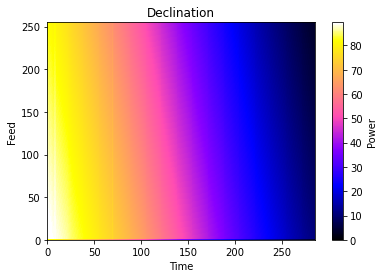

In [46]:
x = np.arange(len(Dec_m[255,tlb:tub]))
y = np.arange(len(Dec_m[255:511,tlb]))
z = Dec_m[255:511,tlb:tub]

print(x.shape)
print(y.shape)
print(z.shape)

# Plotting
plt.pcolormesh(x, y, z, cmap='gnuplot2', vmin=0)
plt.colorbar().set_label('Power')
plt.title('Declination')
plt.ylabel('Feed')
plt.xlabel('Time')
#plt.xlim(207,494)
plt.show()

In [82]:
subarray = NSconcat.V[tlb:tub,:,255+75]
decVal = Dec_m[255+75, tlb:tub]

print(subarray.shape)
print(decVal.shape)

NSconcatDec = np.empty([286, 1024], dtype=float)
for i in range(NSconcatDec.shape[0]):
    NSconcatDec[i]=subarray[i]
    
print(NSconcatDec.shape)

(286, 1024)
(286,)
(286, 1024)


In [42]:
import numpy as np

# Example data, replace with your actual data
NSconcat_V = np.random.rand(800, 100, 512)  # Shape (time, frequency, feed)
Dec_m = np.random.rand(512, 800)  # Shape (feed, time)
tlb, tub = 187, 493  # Time range

# Extract the subarray from NSconcat.V
subarray = NSconcat_V[tlb:tub, 50, 256:511]

# Extract the corresponding declination values from Dec_m
decVal = Dec_m[255 + 75, tlb:tub]

# Check the shapes
print("Shape of subarray (power):", subarray.shape)
print("Shape of decVal (declination):", decVal.shape)

# Combine the extracted data into a new array
# Assuming you want to replace the time axis (first axis) with declination values
# Create an empty array with the new shape
new_array_shape = (decVal.shape[0], subarray.shape[1])
new_array = np.empty(new_array_shape)

# Fill the new array with the power values, indexed by declination values
for i in range(new_array_shape[0]):
    new_array[i] = subarray[i]

# Print the shape of the new array to verify
print("Shape of new_array:", new_array.shape)


Shape of subarray (power): (306, 255)
Shape of decVal (declination): (306,)
Shape of new_array: (306, 255)


In [34]:
import matplotlib.pyplot as plt
x = np.arange(Dec_m[255:511, tlb:tub].shape[1])
y = np.arange(Dec_m[255:511, tlb:tub].shape[0])
z = Dec_m[255:511, tlb:tub]

print(x.shape)
print(y.shape)
print(z.shape)

plt.pcolormesh(NSconcat.V[tlb:tub,50,255:511], cmap='gnuplot2')
plt.colorbar().set_label('Power')
plt.title('Amplitude (time v feed), freq [36]')
plt.ylabel('Feed')
plt.xlabel('Time')
plt.show()

(286,)
(256,)
(256, 286)


IndexError: arrays used as indices must be of integer (or boolean) type

<ipython-input-25-128c336241c4>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x, y, z, cmap='gnuplot2')


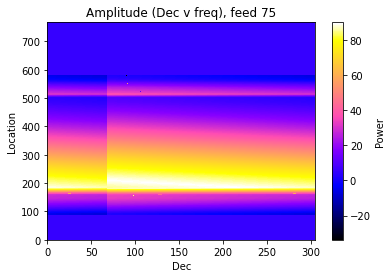

In [25]:
y = np.arange(RA_m[tlb:tub, :].shape[1])
x = np.arange(RA_m[tlb:tub, :].shape[0])
z = np.transpose(Dec_m[tlb:tub, :])

# Plotting
plt.pcolormesh(x, y, z, cmap='gnuplot2')
plt.colorbar().set_label('Power')
plt.title('Amplitude (Dec v freq), feed 75')
plt.ylabel('Location')
plt.xlabel('Dec')
plt.show()

In [26]:
print(np.transpose(NSconcat.V[tlb:tub,:,75+256].shape))

[ 286 1024]


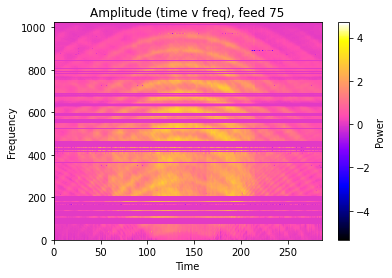

In [86]:
tlb, tub = [207,493]

plt.pcolormesh(np.transpose(NSconcat.V[tlb:tub,:,75+256]), cmap='gnuplot2') #Don't forget to add 256, otherwise you get an empty plot due to wrong polarization
plt.colorbar().set_label('Power')
plt.title('Amplitude (time v freq), feed 75')
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.show()

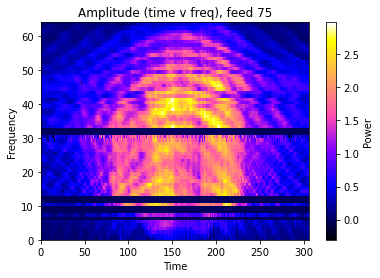

In [57]:
tlb, tub = [187,493]

plt.pcolormesh(np.transpose(NSN2concat.V[tlb:tub,:,75+256]), cmap='gnuplot2') #Don't forget to add 256, otherwise you get an empty plot due to wrong polarization
plt.colorbar().set_label('Power')
plt.title('Amplitude (time v freq), feed 75')
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.show()

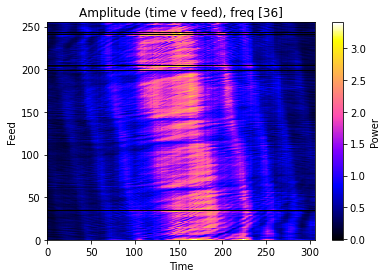

In [47]:
tlb, tub = [187,493]

plt.pcolormesh(np.transpose(NSN2concat.V[tlb:tub,50,256:511]), cmap='gnuplot2')
plt.colorbar().set_label('Power')
plt.title('Amplitude (time v feed), freq [36]')
plt.ylabel('Feed')
plt.xlabel('Time')
plt.show()

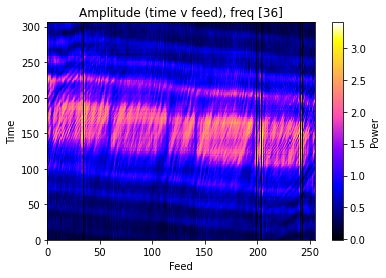

In [44]:
tlb, tub = [187,493]

plt.pcolormesh(NSN2concat.V[tlb:tub,50,256:511], cmap='gnuplot2')
plt.colorbar().set_label('Power')
plt.title('Amplitude (time v feed), freq [36]')
plt.ylabel('Time')
plt.xlabel('Feed')
plt.show()

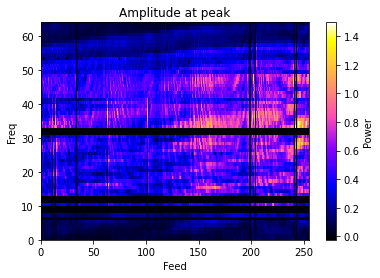

In [36]:
plt.pcolormesh(NSN2concat.V[208,:,256:511], cmap='gnuplot2')
plt.colorbar().set_label('Power')
plt.title('Amplitude at peak')
plt.xlabel('Feed')
plt.ylabel('Freq')
plt.show()

In [ ]:
datadirp='/hirax/CHIME_Oct_2022/20221028T193747Z_chimedronegatedN2_corr/'
fnp='00003495_0000.h5'
fd_np=h5py.File(datadirp+fnp, 'r')

index_map=fd_np['index_map']
blTot = 131328
blMatrix = np.zeros((512,512), dtype=int)

for i in range(blTot):
    x,y=index_map['prod'][i]
    blMatrix[x,y] = i 

diagEnt = np.diagonal(blMatrix) #512 indexes
vis=np.array(fd_np['vis']).transpose(2,0,1) #time, freq, entry
print(vis.shape)

freqList = np.array([item['centre'] for item in index_map['freq'][:]], dtype=float)